**SWEDISH HOUSING PREDICTION - MODEL**

# 0 - Data Import

In [ ]:
import pandas as pd                              
import matplotlib.pyplot as plt                 
import json as json                                                             
import numpy as np                              
import seaborn as sns 
import xgboost as xgb                          

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # No column width truncation
pd.set_option('display.width', 1000)  # Adjust the width of the table

In [ ]:
#load df
annualreport_df = pd.read_csv('AnnualReport.csv')
apartment_df = pd.read_csv('Apartment.csv')
housingassociation_df = pd.read_csv('HousingAssociation.csv')

In [ ]:
annualreport_joined = annualreport_df.merge(housingassociation_df, on='org_number', how='left')

apartment_df['sell_date'] = pd.to_datetime(apartment_df['sell_date'])

#Create fiscal year to join
apartment_df['fiscal_year'] = apartment_df['sell_date'].dt.year

apartment_joined = apartment_df.merge(annualreport_joined, left_on=['housing_association_org_number', 'fiscal_year'], right_on=['org_number', 'fiscal_year'], how='left')
apartment_joined.drop(['org_number'], axis=1, inplace=True)
apartment_joined.head()

,Unnamed: 0,id,additional_area,agency_id,amenities,asking_price,brokers_description,cover_photo_description,customer_area_description,district,energy_class,floor,has_balcony,has_fireplace,has_patio,has_solar_panels,heating,height,housing_association_fee,housing_association_org_number,id2,index,is_new_construction,key,latitude,living_area,locality,location,longitude,municipality,object_type,operating_cost,plot_area,populated_area,postcode,primary_area,region,rooms,sell_date,street_address,width,sell_price,fiscal_year,Unnamed: 0_x,association_tax_liability,long_term_debt_other,long_term_real_estate_debt,number_of_rental_units,number_of_units,plot_is_leased,savings,total_commercial_area,total_living_area,total_loan,total_plot_area,total_rental_area,Unnamed: 0_y,name,construction_year,housing_coop_id
0,0,00001ce3c1dde1c941837a0e5d3bfee4,NaN,26.0,NaN,NaN,Karlshamns kommun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2095676-2016-05-19,186932,NaN,NaN,56.165330,120.0,NaN,Södra Sverige,14.880469,Karlshamn,Rowhouse,2475.0,206.0,Karlshamn,37434.0,Karlshamn,Blekinge län,5.0,2016-05-19,Hunnemaravägen 49,NaN,2900000.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0000427e3712a9d0839d903d34ed3dcf,NaN,400.0,NaN,590000.0,Kristinehamn,NaN,Centrum,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5309.0,716411-2356,3184962-2018-07-04,803234,NaN,NaN,59.308009,86.0,NaN,Mellersta Sverige,14.107737,Kristinehamn,Apartment,NaN,NaN,Kristinehamn,68131.0,Kristinehamn,Värmlands län,3.0,2018-07-04,Spelmansgatan 34,NaN,680000.0,2018,9910.0,lowered_tax_liability,0.0,45821318.0,0.0,57.0,0.0,410000.0,0.0,4654.0,45821318.0,0.0,0.0,2782.0,HSB Brf Capella i Kristinehamn,1988.0,51850.0
2,2,000046b15639c0808f53b408c0cca63d,NaN,NaN,NaN,NaN,Riksby,NaN,Västerort,Bromma,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2893.0,702001-7807,4101858-2021-02-05,76752,NaN,NaN,59.340393,54.0,Riksby,Storstockholm,17.942555,Stockholm,Apartment,375.0,NaN,NaN,16874.0,Bromma,Stockholms län,NaN,2021-02-05,Kvarnbacksvägen 123,NaN,3000000.0,2021,1279.0,lowered_tax_liability,40000.0,26780000.0,0.0,318.0,1.0,69000.0,1557.0,16014.0,26820000.0,0.0,0.0,405.0,BRF Riksby,1942.0,54027.0
3,3,000069b14f835d4e3ace0507c65eca8c,NaN,16.0,NaN,1795000.0,Tyresö Strand,NaN,Stockholms skärgård,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3354.0,769606-6088,3382270-2019-04-24,933841,NaN,NaN,59.243462,42.0,NaN,Storstockholm,18.284143,Tyresö,Apartment,463.0,NaN,NaN,13563.0,Tyresö,Stockholms län,2.0,2019-04-24,Målarprinsens väg 2,NaN,1940000.0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,00007b869dea7243f1da92b265261807,NaN,12.0,elevator,NaN,Tureberg,NaN,Bagarby,NaN,NaN,4.0,NaN,NaN,NaN,NaN,district,NaN,3870.0,769636-4137,5208727-2024-02-08,808147,NaN,NaN,59.427760,94.0,NaN,Storstockholm,17.944397,Sollentuna,Apartment,453.0,NaN,NaN,19160.0,Sollentuna,Stockholms län,4.0,2024-02-08,Malmvägen 16C,NaN,2750000.0,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Need to format these features from float to int64
columns_to_convert = ['housing_coop_id', 'construction_year', 'number_of_units', 'number_of_rental_units', 'rooms', 'postcode', 'floor', 'agency_id']
apartment_joined[columns_to_convert] = apartment_joined[columns_to_convert].astype('Int64')
apartment_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668801 entries, 0 to 668800
Data columns (total 60 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unnamed: 0                      668801 non-null  int64         
 1   id                              668801 non-null  object        
 2   additional_area                 26054 non-null   float64       
 3   agency_id                       559867 non-null  Int64         
 4   amenities                       87235 non-null   object        
 5   asking_price                    482084 non-null  float64       
 6   brokers_description             668801 non-null  object        
 7   cover_photo_description         359 non-null     object        
 8   customer_area_description       585396 non-null  object        
 9   district                        235391 non-null  object        
 10  energy_class                    55095 non-null   object 

In [5]:
apartment_joined.rename(columns={
    'name': 'housing_association_name',
    'savings': 'housing_association_savings'
    }, inplace=True)

# 1 - Data Preprocessing

In [111]:
variables_to_keep = ['sell_price',
                     'asking_price',
                     'rooms',
                     'latitude',
                     'longitude',
                     'object_type',
                     'association_tax_liability',
                     'sell_date',
                     'floor',
                     'municipality',
                     'postcode',
                     'region',
                     'location',            # Contains 6 unique values Södra Sverige', 'Mellersta Sverige', 'Storstockholm', 'Stormalmö', 'Norra Sverige', 'Storgöteborg', nan. Contains 61 missing values.
                     'living_area',
                     'housing_association_fee',
                     'id'
                    ]

new_training_data = apartment_joined[variables_to_keep]

## Missing Values
* asking_price: Fill with median postcode asking_price
* rooms: fill with median
* association_tax_liabilty: impute with lowered_tax_liability
* floor: impute with median
* postcode: impute with mode
* region: impute with mode
* location: impute with mode
* living_area: impute with median
* housing_association_fee: impute with median

- For features < 10% missing value, impute them with Median / Mode
- For the others: asking_price - we use rules from postcode, and impute association_tax_liability with lowered_tax_liability for NA values - by Swedish market sense

In [114]:
# Create a new DataFrame for the cleaned data
training_cleaned = new_training_data.copy()

# 1. Fill 'postcode' with the mode
postcode_mode = training_cleaned['postcode'].mode()[0]
training_cleaned['postcode'] = training_cleaned['postcode'].fillna(postcode_mode)

# 2a: Fill 'asking_price' with the median per 'postcode'
training_cleaned['asking_price'] = training_cleaned.groupby('postcode')['asking_price'].transform(
    lambda x: x.fillna(x.median())
)

# Step 2b: Impute remaining NaNs with median per 'object_type'
training_cleaned['asking_price'] = training_cleaned.groupby('object_type')['asking_price'].transform(
    lambda x: x.fillna(x.median())
)

# 3. Fill 'rooms' with the overall median
training_cleaned['rooms'] = training_cleaned['rooms'].fillna(training_cleaned['rooms'].median())

# 4. Fill 'association_tax_liability' with the string 'lowered_tax_liability'
training_cleaned['association_tax_liability'] = training_cleaned['association_tax_liability'].fillna('lowered_tax_liability')

# 5. Fill 'floor' with the overall median
training_cleaned['floor'] = training_cleaned['floor'].fillna(training_cleaned['floor'].median())

# 6. Fill 'region' with the mode
region_mode = training_cleaned['region'].mode()[0]
training_cleaned['region'] = training_cleaned['region'].fillna(region_mode)

# 7. Fill 'location' with the mode
location_mode = training_cleaned['location'].mode()[0]
training_cleaned['location'] = training_cleaned['location'].fillna(location_mode)

# 8. Fill 'living_area' with the median living_area
training_cleaned['living_area'] = training_cleaned['living_area'].fillna(training_cleaned['living_area'].median())

# 9. Fill 'housing_association_fee' with the median per object type
training_cleaned['housing_association_fee'] = training_cleaned.groupby('object_type')['housing_association_fee'].transform(
    lambda x: x.fillna(x.median())
)

# Check for remaining NaNs and save the cleaned data (optional)
print(training_cleaned.isna().sum())  # Ensure no missing values remain

c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanme

sell_price                   19255
asking_price                     0
rooms                            0
latitude                         0
longitude                        0
object_type                      0
association_tax_liability        0
sell_date                        0
floor                            0
municipality                     1
postcode                         0
region                           0
location                         0
living_area                      0
housing_association_fee          0
id                               0
dtype: int64


In [115]:
# Ensure no missing values remain
print(training_cleaned.isna().sum()) 

sell_price                   19255
asking_price                     0
rooms                            0
latitude                         0
longitude                        0
object_type                      0
association_tax_liability        0
sell_date                        0
floor                            0
municipality                     1
postcode                         0
region                           0
location                         0
living_area                      0
housing_association_fee          0
id                               0
dtype: int64


## Handle Zero Sell Price

In [116]:
print("Zero Values: ", (training_cleaned['sell_price'] == 0).sum())

Zero Values:  1


In [117]:
# Calculate the median of the sell_price column
median_sell_price = training_cleaned['sell_price'].median()

# Replace zero values with the median
training_cleaned['sell_price'] = training_cleaned['sell_price'].replace(0, median_sell_price)

# Verify that there are no more zero values
print("Zero Values After Imputation: ", (training_cleaned['sell_price'] == 0).sum())

Zero Values After Imputation:  0


## Add some features

In [ ]:
# Feature: Sell year
training_cleaned['year_of_sale'] = pd.to_datetime(training_cleaned['sell_date']).dt.year

# Feature: is_coivd
training_cleaned['is_covid'] = ((training_cleaned['year_of_sale'] >= 2020) & 
                             (training_cleaned['year_of_sale'] <= 2022)).astype(int)

# Drop intermediate columns
training_cleaned = training_cleaned.drop(['sell_date'], axis=1)

## Drop Values before 2012
Less data availability and different environment renders this data unsuited for use in analysis. Improvement in model performance was confirmend by comparing experimental models earlier in the process.

In [119]:
training_cleaned = training_cleaned[training_cleaned['year_of_sale'] >= 2012]

training_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665266 entries, 0 to 668800
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   sell_price                 646011 non-null  float64
 1   asking_price               665266 non-null  float64
 2   rooms                      665266 non-null  Int64  
 3   latitude                   665266 non-null  float64
 4   longitude                  665266 non-null  float64
 5   object_type                665266 non-null  object 
 6   association_tax_liability  665266 non-null  object 
 7   floor                      665266 non-null  Int64  
 8   municipality               665265 non-null  object 
 9   postcode                   665266 non-null  Int64  
 10  region                     665266 non-null  object 
 11  location                   665266 non-null  object 
 12  living_area                665266 non-null  float64
 13  housing_association_fee    665266 

## Drop some more variables

Drop variabels used to create features, not needed anymore

In [120]:
drop = ['municipality', 'postcode', 'region']
training_cleaned = training_cleaned.drop(drop, axis=1)
training_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665266 entries, 0 to 668800
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   sell_price                 646011 non-null  float64
 1   asking_price               665266 non-null  float64
 2   rooms                      665266 non-null  Int64  
 3   latitude                   665266 non-null  float64
 4   longitude                  665266 non-null  float64
 5   object_type                665266 non-null  object 
 6   association_tax_liability  665266 non-null  object 
 7   floor                      665266 non-null  Int64  
 8   location                   665266 non-null  object 
 9   living_area                665266 non-null  float64
 10  housing_association_fee    665266 non-null  float64
 11  id                         665266 non-null  object 
 12  year_of_sale               665266 non-null  int32  
 13  is_covid                   665266 

## Encode the categorical features

In [ ]:
encode_columns = ['object_type', 'location', 'association_tax_liability']

encoder = OneHotEncoder(drop=None, sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('encode', encoder, encode_columns)  
    ],
    remainder='passthrough',               
    verbose_feature_names_out=False        
)

encoded_array = preprocessor.fit_transform(training_cleaned)

all_column_names = preprocessor.get_feature_names_out()

# Check if dimensions match
print(f"Shape of transformed array: {encoded_array.shape}")
print(f"Number of column names: {len(all_column_names)}")

# Handle mixed data types
encoded_df = pd.DataFrame(encoded_array, columns=all_column_names)

for col in encoded_df.columns:
    try:
        encoded_df[col] = pd.to_numeric(encoded_df[col], errors='ignore')
    except ValueError:
        pass  # If conversion fails, leave as is

print(encoded_df.head())
print(encoded_df.dtypes)  # Check data types

Shape of transformed array: (665266, 24)
Number of column names: 24


C:\Users\a00578421\AppData\Local\Temp\ipykernel_25596\1586997378.py:33: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  encoded_df[col] = pd.to_numeric(encoded_df[col], errors='ignore')


   object_type_Apartment  object_type_Chain House  object_type_Rowhouse  object_type_Twin House  location_Mellersta Sverige  location_Norra Sverige  location_Storgöteborg  location_Stormalmö  location_Storstockholm  location_Södra Sverige  association_tax_liability_lowered_tax_liability  association_tax_liability_other  association_tax_liability_standard_tax_liability  sell_price  asking_price  rooms   latitude  longitude  floor  living_area  housing_association_fee                                id  year_of_sale  is_covid
0                    0.0                      0.0                   1.0                     0.0                         0.0                     0.0                    0.0                 0.0                     0.0                     1.0                                              1.0                              0.0                                               0.0   2900000.0      595000.0      5  56.165330  14.880469      2        120.0                   5105.0 

In [122]:
encoded_df['year_of_sale'] = encoded_df['year_of_sale'].astype(int)

## Save the grading set from the data and save it in separate df.

In [ ]:
# Create a new DataFrame grading_set with rows where sell_date is missing
grading_set = encoded_df[encoded_df['sell_price'].isnull()]

# Remove these rows from scaled_training_data
encoded_df = encoded_df[encoded_df['sell_price'].notnull()]

# Verify 2 sets
print(f"Grading set shape: {grading_set.shape}")
print(f"Scaled training data shape: {encoded_df.shape}")

Grading set shape: (19255, 24)
Scaled training data shape: (646011, 24)


In [125]:
grading_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19255 entries, 8 to 665200
Data columns (total 24 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   object_type_Apartment                             19255 non-null  float64
 1   object_type_Chain House                           19255 non-null  float64
 2   object_type_Rowhouse                              19255 non-null  float64
 3   object_type_Twin House                            19255 non-null  float64
 4   location_Mellersta Sverige                        19255 non-null  float64
 5   location_Norra Sverige                            19255 non-null  float64
 6   location_Storgöteborg                             19255 non-null  float64
 7   location_Stormalmö                                19255 non-null  float64
 8   location_Storstockholm                            19255 non-null  float64
 9   location_Södra Sverig

## Ensure that no missing values remain

Check for df for training

In [ ]:
# Check for missing values and display only columns with missing values
missing_values = encoded_df.isnull().sum()
columns_with_missing = missing_values[missing_values > 0] 

print("Columns with missing values:")
print(columns_with_missing)

Columns with missing values:
Series([], dtype: int64)


Check for Grading Set

In [ ]:
# Check for missing values and display only columns with missing values
missing_values = grading_set.isnull().sum()
columns_with_missing = missing_values[missing_values > 0]

print("Columns with missing values:")
print(columns_with_missing)

# Missing sell prices (19255); expected.

Columns with missing values:
sell_price    19255
dtype: int64


## Outliers

In [128]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 646011 entries, 0 to 665265
Data columns (total 24 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   object_type_Apartment                             646011 non-null  float64
 1   object_type_Chain House                           646011 non-null  float64
 2   object_type_Rowhouse                              646011 non-null  float64
 3   object_type_Twin House                            646011 non-null  float64
 4   location_Mellersta Sverige                        646011 non-null  float64
 5   location_Norra Sverige                            646011 non-null  float64
 6   location_Storgöteborg                             646011 non-null  float64
 7   location_Stormalmö                                646011 non-null  float64
 8   location_Storstockholm                            646011 non-null  float64
 9   location_

To not train our models on extreme sell_prices, we drop the highest 5%.

In [ ]:
def remove_top_5_percent_per_year(data, column, group_column):
    # Define a function to filter out the top 5% for each group
    def filter_group(group):
        threshold = group[column].quantile(0.95)  
        return group[group[column] <= threshold] 

    return data.groupby(group_column, group_keys=False).apply(filter_group)

# Remove  top 5% highest sell prices per year
encoded_df = remove_top_5_percent_per_year(encoded_df, column='sell_price', group_column='year_of_sale')

print(f"Encoded training data shape: {encoded_df.shape}")

Encoded training data shape: (613988, 24)


C:\Users\a00578421\AppData\Local\Temp\ipykernel_25596\1953288342.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(group_column, group_keys=False).apply(filter_group)


# 2 - Train/Test Split

To train our models, we use data before 2023 to train our model, and data after 2023 to test our model. This approach was chosen as we'll be evaluated on the grading set, consisting of missing sell prices for the period 2024/08-2024/11. This corresponds to approximately a 80/20 train/test split.

Drop the 'id' column before splitting the data

In [ ]:
encoded_df = encoded_df.drop(columns=['id'])

train_data = encoded_df[encoded_df['year_of_sale'] < 2023]  # Data from before 2023
test_data = encoded_df[encoded_df['year_of_sale'] >= 2023]  # Data from 2023 and onward

X_train = train_data.drop(columns=['sell_price'])
y_train = train_data['sell_price']

X_test = test_data.drop(columns=['sell_price'])
y_test = test_data['sell_price']

# Display  shapes of  resuts 
print(f"Training data: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Testing data: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

In [ ]:
print(X_train.dtypes)

object_type_Apartment                               float64
object_type_Chain House                             float64
object_type_Rowhouse                                float64
object_type_Twin House                              float64
location_Mellersta Sverige                          float64
location_Norra Sverige                              float64
location_Storgöteborg                               float64
location_Stormalmö                                  float64
location_Storstockholm                              float64
location_Södra Sverige                              float64
association_tax_liability_lowered_tax_liability     float64
association_tax_liability_other                     float64
association_tax_liability_standard_tax_liability    float64
asking_price                                        float64
rooms                                                 int64
latitude                                            float64
longitude                               

In [ ]:
X_train.head()

,object_type_Apartment,object_type_Chain House,object_type_Rowhouse,object_type_Twin House,location_Mellersta Sverige,location_Norra Sverige,location_Storgöteborg,location_Stormalmö,location_Storstockholm,location_Södra Sverige,association_tax_liability_lowered_tax_liability,association_tax_liability_other,association_tax_liability_standard_tax_liability,asking_price,rooms,latitude,longitude,floor,living_area,housing_association_fee,year_of_sale,is_covid
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,895000.0,2,55.565117,12.989531,2,66.0,3280.0,2012,0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2572500.0,3,55.699141,13.190657,2,81.0,6460.0,2012,0
61,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1250000.0,3,63.388886,13.099760,2,80.0,4128.0,2012,0
116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,325000.0,4,58.347991,12.338808,2,119.0,7008.0,2012,0
219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,95000.0,3,58.167915,13.570917,2,74.0,4236.0,2012,0


# 3 - Baseline Model: Gradient Boost

In [ ]:
# Ensure no missing values in the data
if X_train.isnull().any().any() or X_test.isnull().any().any() or y_train.isnull().any() or y_test.isnull().any():
    raise ValueError("Missing values detected in the training or testing data.")


gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

# Evaluation metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

results = pd.DataFrame({
    "Metric": ["MAE", "MAPE (%)", "R²"],
    "Train": [train_mae, train_mape, train_r2],
    "Test": [test_mae, test_mape, test_r2]
})

# Print the table in LaTeX format
print(results.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
Metric & Train & Test \\
\midrule
MAE & 268127.65 & 383788.07 \\
MAPE (%) & 15.43 & 18.52 \\
R² & 0.87 & 0.85 \\
\bottomrule
\end{tabular}



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


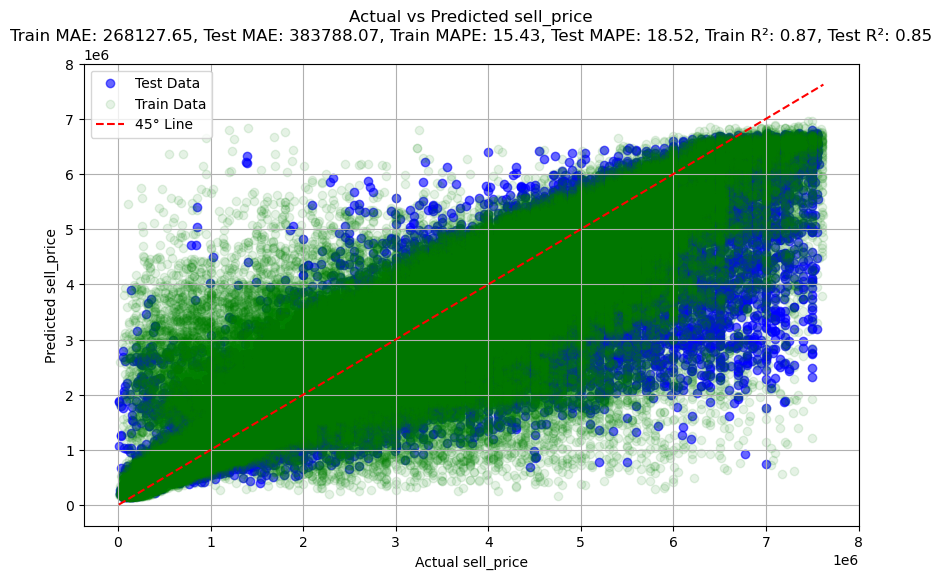

In [ ]:
# Visualize the results

min_val = min(y_test.min(), y_pred_test.min(), y_train.min(), y_pred_train.min())
max_val = max(y_test.max(), y_pred_test.max(), y_train.max(), y_pred_train.max())

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data', alpha=0.6)
plt.scatter(y_train, y_pred_train, color='green', label='Train Data', alpha=0.1)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='45° Line')

plt.xlabel('Actual sell_price')
plt.ylabel('Predicted sell_price')
plt.title(f'Actual vs Predicted sell_price\n'
          f'Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}, '
          f'Train MAPE: {train_mape:.2f}, Test MAPE: {test_mape:.2f}, '
          f'Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# 4 - Challenger: Decision Tree

To make this easier to run, we optimize the hyperparameters in a first step, and then manually run the model in a second step, where we manually input the optimal depth obtained in the first step. 

**No need to run first code, just for optimization. Second code has values manually entered**

## Decision Tree, without tuning

In [ ]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
test_r2 = r2_score(y_test, y_pred_test)

# Print metrics in LaTeX format
metrics_df = pd.DataFrame({
    'Metric': ['Train MAE', 'Train MAPE (%)', 'Train R²', 'Test MAE', 'Test MAPE (%)', 'Test R²'],
    'Value': [train_mae, train_mape, train_r2, test_mae, test_mape, test_r2]
})
latex_metrics_table = metrics_df.to_latex(index=False, float_format="%.2f", caption="Decision Tree Evaluation Metrics")
print(latex_metrics_table)

\begin{table}
\caption{Decision Tree Evaluation Metrics}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Train MAE & 994.16 \\
Train MAPE (%) & 0.04 \\
Train R² & 1.00 \\
Test MAE & 442275.23 \\
Test MAPE (%) & 21.30 \\
Test R² & 0.76 \\
\bottomrule
\end{tabular}
\end{table}



In [38]:
metrics_df.head(10)

,Metric,Value
0,Train MAE,994.163793
1,Train MAPE (%),0.042441
2,Train R²,0.999834
3,Test MAE,442275.227315
4,Test MAPE (%),21.302059
5,Test R²,0.755067


## Decision Tree, with tuning

First, we decide to find the best max_depth, by running a loop from 20 to 30 depth. You do not need to run this code below

In [ ]:
#No Need to run this code!

depth_range = range(20, 31)

results = []

for depth in depth_range:
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'max_depth': depth,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'test_r2': test_r2
    })

results_df = pd.DataFrame(results)

In [ ]:
results_df.head(20)

,max_depth,train_mae,train_mape,train_r2,test_mae,test_mape,test_r2
0,20,125895.163433,0.070622,0.967519,406299.645861,0.198470,0.778688
1,21,110449.590197,0.062786,0.973675,408239.710602,0.197852,0.779451
2,22,95434.731091,0.054924,0.979162,417226.460336,0.204337,0.768053
3,23,81577.561585,0.047496,0.983435,423006.308687,0.208468,0.764119
4,24,68836.604761,0.040444,0.987009,429942.167065,0.212507,0.759146
5,25,57472.027826,0.034019,0.989859,430985.440607,0.206402,0.759098
6,26,47408.558001,0.028222,0.992122,434074.312852,0.213155,0.755926
7,27,38797.118315,0.023158,0.993853,432763.867956,0.211442,0.760694
8,28,31418.195386,0.018689,0.995223,438791.610754,0.213448,0.753696
9,29,25204.142554,0.014909,0.996275,435175.475717,0.210473,0.758546


In [42]:
# Find the best_depth

best_row = results_df.loc[results_df['test_mae'].idxmin()]
best_depth = best_row['max_depth']
print(f"Best depth: {best_depth}")

Best depth: 20.0


With depth = 20, not only the test_mape is lowest, but also the gap between train_mape & test_mape also lowest as well --> We don't have overfit problem

**Fit model with manual input to make code faster for evaluation**

In [136]:
# Manually specify the best depth from the optimization process
best_depth = 20  # Replace with the optimal depth you determined earlier

# Train the Decision Tree with the chosen depth
model = DecisionTreeRegressor(random_state=42, max_depth=best_depth)
model.fit(X_train, y_train)

# Predict on training and testing sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
test_r2 = r2_score(y_test, y_pred_test)

# Print metrics in LaTeX format
metrics_df = pd.DataFrame({
    'Metric': ['Train MAE', 'Train MAPE (%)', 'Train R²', 'Test MAE', 'Test MAPE (%)', 'Test R²'],
    'Value': [train_mae, train_mape, train_r2, test_mae, test_mape, test_r2]
})
latex_metrics_table = metrics_df.to_latex(index=False, float_format="%.2f", caption="Decision Tree Evaluation Metrics")
print(latex_metrics_table)

\begin{table}
\caption{Decision Tree Evaluation Metrics}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Train MAE & 125895.16 \\
Train MAPE (%) & 7.06 \\
Train R² & 0.97 \\
Test MAE & 406299.65 \\
Test MAPE (%) & 19.85 \\
Test R² & 0.78 \\
\bottomrule
\end{tabular}
\end{table}



In [134]:
metrics_df.head(10)

,Metric,Value
0,Train MAE,125895.163433
1,Train MAPE (%),7.062196
2,Train R²,0.967519
3,Test MAE,406299.645861
4,Test MAPE (%),19.847002
5,Test R²,0.778688


**Visualize the plot - Actual vs. Predicted**

C:\Users\a00578421\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


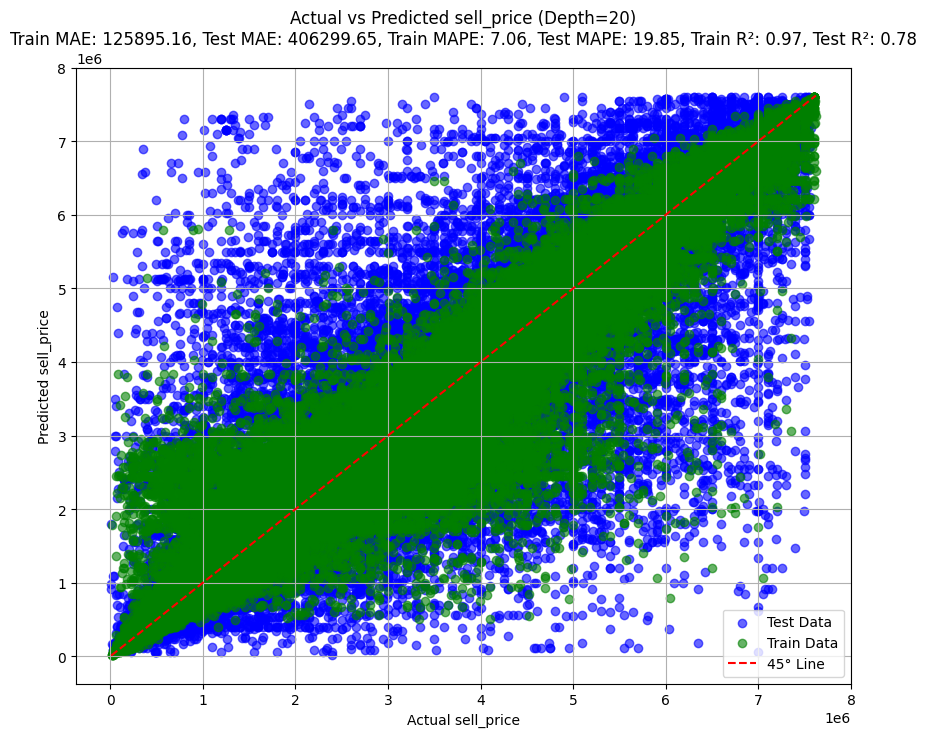

In [137]:
# Scatter plot of actual vs. predicted sell prices
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data', alpha=0.6)
plt.scatter(y_train, y_pred_train, color='green', label='Train Data', alpha=0.6)
plt.plot(
    [min(y_test.min(), y_train.min()), max(y_test.max(), y_train.max())],
    [min(y_test.min(), y_train.min()), max(y_test.max(), y_train.max())],
    color='red', linestyle='--', label='45° Line'
)
plt.xlabel('Actual sell_price')
plt.ylabel('Predicted sell_price')
plt.title(f'Actual vs Predicted sell_price (Depth={best_depth})\n'
          f'Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}, '
          f'Train MAPE: {train_mape:.2f}, Test MAPE: {test_mape:.2f}, '
          f'Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# 5 - Champion: XGBoost

## XGBoost without Tuning

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
test_r2 = r2_score(y_test, y_pred_test)

results = pd.DataFrame({
    "Metric": ["MAE", "MAPE (%)", "R²"],
    "Train": [train_mae, train_mape, train_r2],
    "Test": [test_mae, test_mape, test_r2]
})

# Generate LaTeX output for the metrics table
latex_output = results.to_latex(index=False, float_format="%.2f")
print("LaTeX Table Output:")
print(latex_output)

LaTeX Table Output:
\begin{tabular}{lrr}
\toprule
Metric & Train & Test \\
\midrule
MAE & 219755.66 & 329920.08 \\
MAPE (%) & 12.38 & 16.36 \\
R² & 0.91 & 0.88 \\
\bottomrule
\end{tabular}



In [47]:
results.head()

,Metric,Train,Test
0,MAE,219755.660329,329920.082023
1,MAPE (%),12.376231,16.362754
2,R²,0.906321,0.881120


Visualize the results

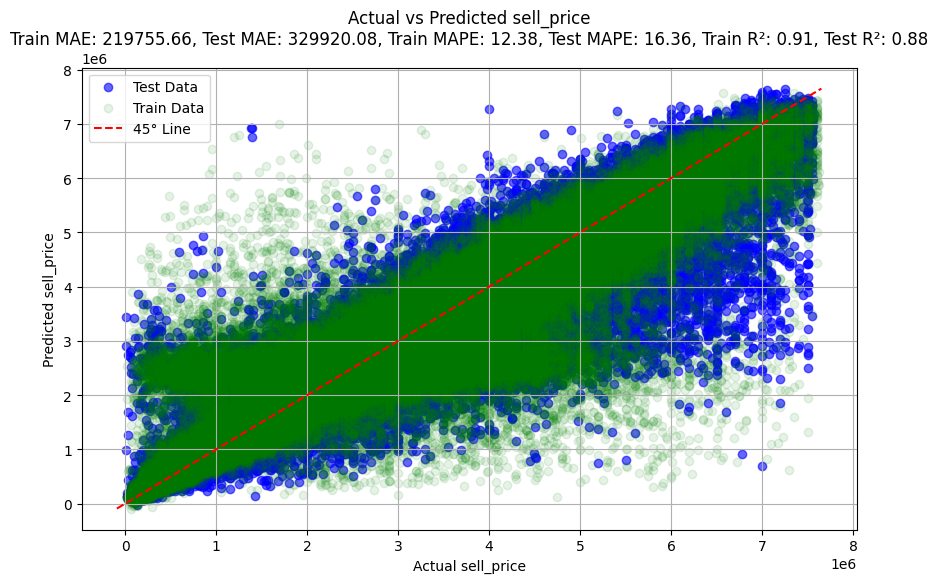

In [ ]:
min_val = min(y_test.min(), y_pred_test.min(), y_train.min(), y_pred_train.min())
max_val = max(y_test.max(), y_pred_test.max(), y_train.max(), y_pred_train.max())

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data', alpha=0.6)
plt.scatter(y_train, y_pred_train, color='green', label='Train Data', alpha=0.1)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='45° Line')

# Add labels and title
plt.xlabel('Actual sell_price')
plt.ylabel('Predicted sell_price')
plt.title(f'Actual vs Predicted sell_price\n'
          f'Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}, '
          f'Train MAPE: {train_mape:.2f}, Test MAPE: {test_mape:.2f}, '
          f'Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost with Tuning

We use RandomizedSearchCV to find the best param configures. No need to run this code below - it will take you some times

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [200, 300, 500, 600],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 9, 13, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 1.0, 1.4],
    'gamma': [0, 0.1, 0.2, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10, 50, 100]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_mean_absolute_error',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Display the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_model = random_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate metrics for train set
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
train_r2 = r2_score(y_train, y_pred_train)

# Calculate metrics for test set
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train Metrics: MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}%, R²: {train_r2:.2f}")
print(f"Test Metrics: MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%, R²: {test_r2:.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\a00578421\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\a00578421\AppData\Local\Programs\Python\Python31

Best Parameters: {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Train Metrics: MAE: 184688.30, MAPE: 10.70%, R²: 0.93
Test Metrics: MAE: 308030.23, MAPE: 15.39%, R²: 0.89


**Model with the optimized parameters so the RandomSearch does not have to be run every time**

Rather than run the code with RandomizedSearchCV above, please run this code!

In [ ]:
# Input the best hyperparameters got from RandomizedSearchCV
best_params = {
    'max_depth': 13,           
    'learning_rate': 0.05,     
    'n_estimators': 300,     
    'subsample': 0.8,       
    'colsample_bytree': 1,  
    'reg_alpha': 0.1,      
    'reg_lambda': 100,
    'gamma': 0.1       
}

final_model = xgb.XGBRegressor(
    random_state=42,
    **best_params
)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_result = {}

final_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

train_loss = final_model.evals_result()['validation_0']['rmse']
test_loss = final_model.evals_result()['validation_1']['rmse']

y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Evaluation Metrics:")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")

Evaluation Metrics:
Train MAE: 185033.02
Test MAE: 306822.38
Train MAPE: 10.72%
Test MAPE: 15.27%
Train R²: 0.93
Test R²: 0.90


Feature Importance from our Champion Model

<Figure size 1200x800 with 0 Axes>

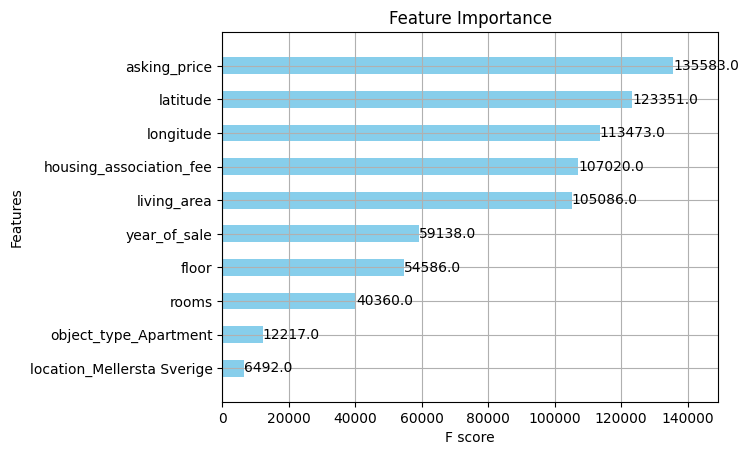

In [ ]:
plt.figure(figsize=(12, 8)) 
xgb.plot_importance(final_model, 
                    importance_type='weight',  
                    max_num_features=10, 
                    title="Feature Importance", 
                    height=0.5,  
                    color='skyblue',  
                    show_values=True) 

# Show the plot
plt.show()

Visualize the plot - Actual vs. Predicted

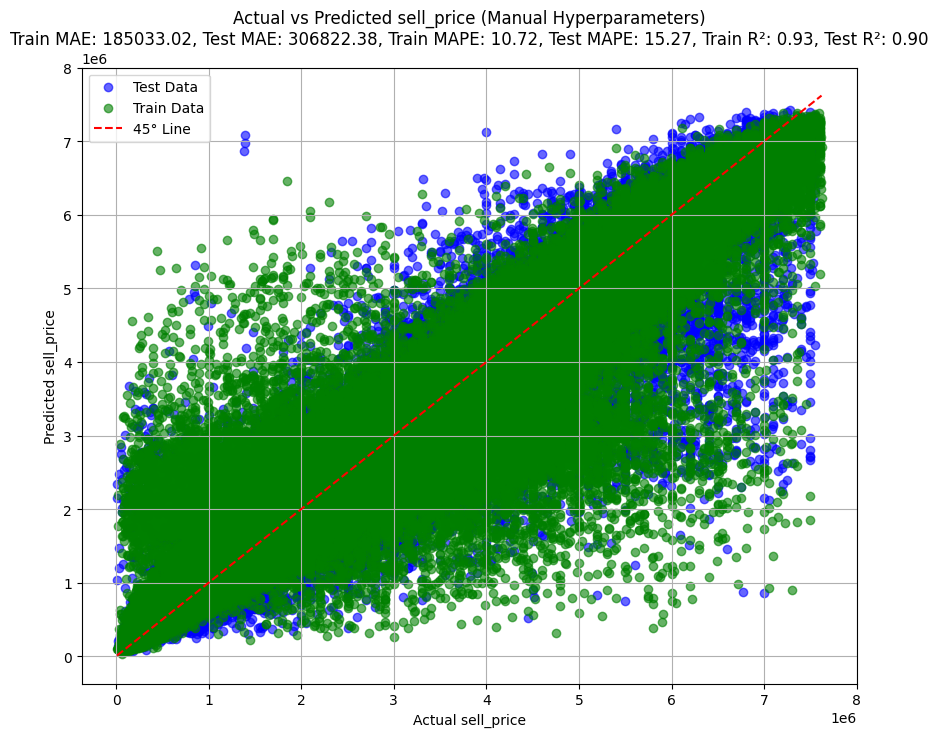

In [56]:
# Scatter plot of actual vs. predicted sell prices
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data', alpha=0.6)
plt.scatter(y_train, y_pred_train, color='green', label='Train Data', alpha=0.6)
plt.plot(
    [min(y_test.min(), y_train.min()), max(y_test.max(), y_train.max())],
    [min(y_test.min(), y_train.min()), max(y_test.max(), y_train.max())],
    color='red', linestyle='--', label='45° Line'
)
plt.xlabel('Actual sell_price')
plt.ylabel('Predicted sell_price')
plt.title(f'Actual vs Predicted sell_price (Manual Hyperparameters)\n'
          f'Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}, '
          f'Train MAPE: {train_mape:.2f}, Test MAPE: {test_mape:.2f}, '
          f'Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

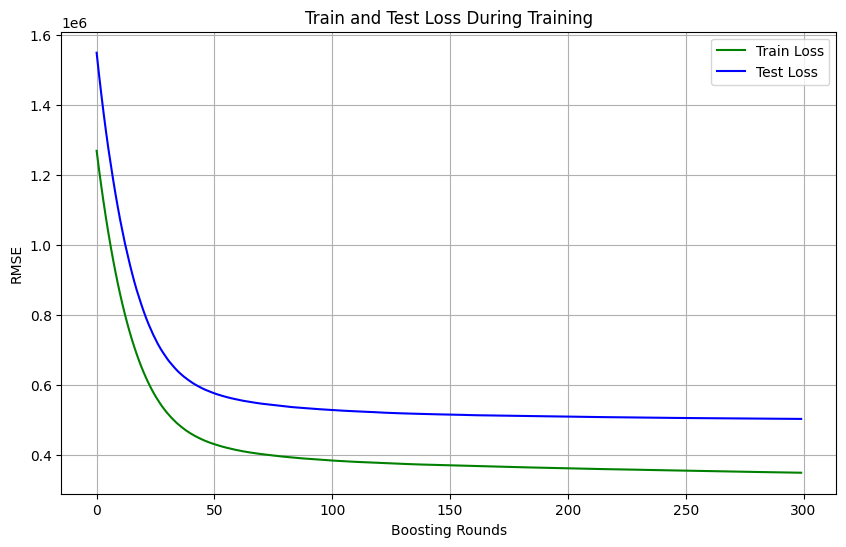

In [57]:
# Plot train and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='green')
plt.plot(test_loss, label='Test Loss', color='blue')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Train and Test Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

# 6 - Apply Champion to Evaluation Set and Save .json

In [52]:
import json

# Step 1: Prepare the grading set features
grading_features = grading_set.drop(columns=['id', 'sell_price'], errors='ignore')  # Exclude 'id' and 'sell_price'
grading_features = grading_features.astype(float)  # Ensure features are numerical

# Step 2: Predict missing sell prices using the final trained model
predicted_prices = final_model.predict(grading_features)

# Step 3: Combine predictions with the IDs into a DataFrame
submission_df = pd.DataFrame({
    'id': grading_set['id'],  # Retain the original 'id' column
    'predicted_sell_price': predicted_prices  # Include predicted prices
})

# Step 4: Save the predictions as a JSON file
submission_json = submission_df.to_dict(orient='records')  # Convert to JSON format
output_file = 'predicted_sale_prices.json'

with open(output_file, 'w') as f:
    json.dump(submission_json, f, indent=4)

print(f"Submission file '{output_file}' created successfully!")


Submission file 'predicted_sale_prices.json' created successfully!
